In [1]:
from __future__ import division
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel, Box2DKernel
from astropy.modeling import models,fitting
from astropy.convolution import convolve
import matplotlib.gridspec as gridspec
from numpy import inf
from math import sqrt
from os import listdir
from os.path import isfile, join

In [2]:
path = r'/Users/caridlin/Documents/GitHub/J0230/Analysis/J0230_icubes.wc.c.c_AGN_sub_iter4_oii.bs_msked_oii2_gaussian.fits'
image = fits.open(path)
h = image[0].header
c = image[0].data
x, y = c.shape
print(x, y)
c_cut = c[3 : 55, 8 : 60]
d = c_cut * 11.7685 * 1e-16
print(d.shape)

55 68
(52, 52)


<IPython.core.display.Javascript object>


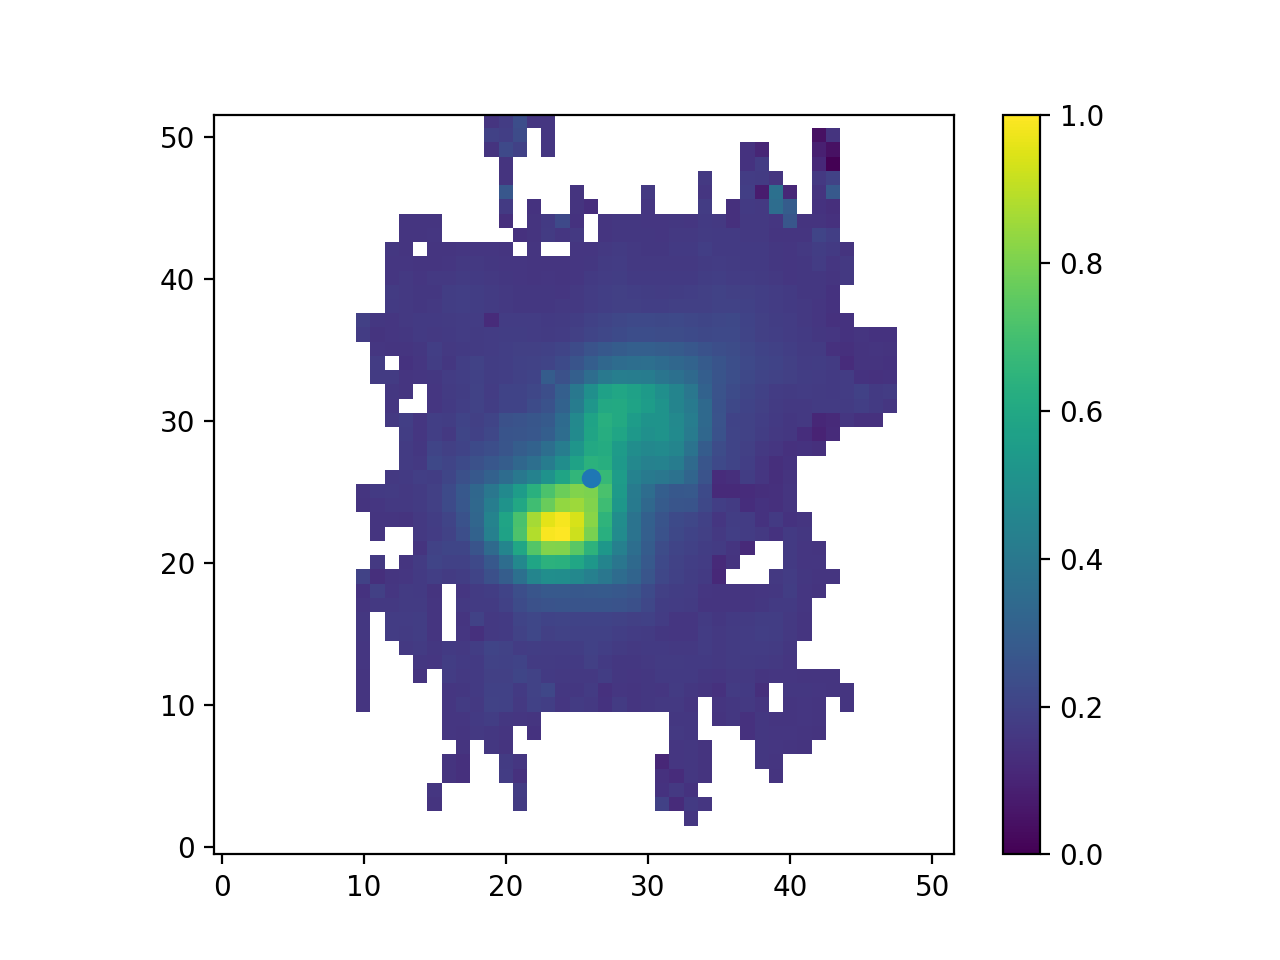

In [3]:
# Convert to line surface brightness
plt.figure()
plt.imshow(d, origin = 'lower')
x0, y0 = 26, 26
plt.scatter(x0, y0)
#plt.contour(SNR, [20], colors = 'red')
plt.colorbar()

In [4]:
def Wind_no_rotation_profile(D, beta0, beta, r0, r):
    return D * (r0 / r) ** 1 * np.heaviside(beta0 - beta, 0) * np.heaviside(r - r0, 0)
    #return D * r0 * (np.exp(1 / r) - 1)* np.heaviside(beta0 - beta, 0) * np.heaviside(r - r0, 0)

<IPython.core.display.Javascript object>


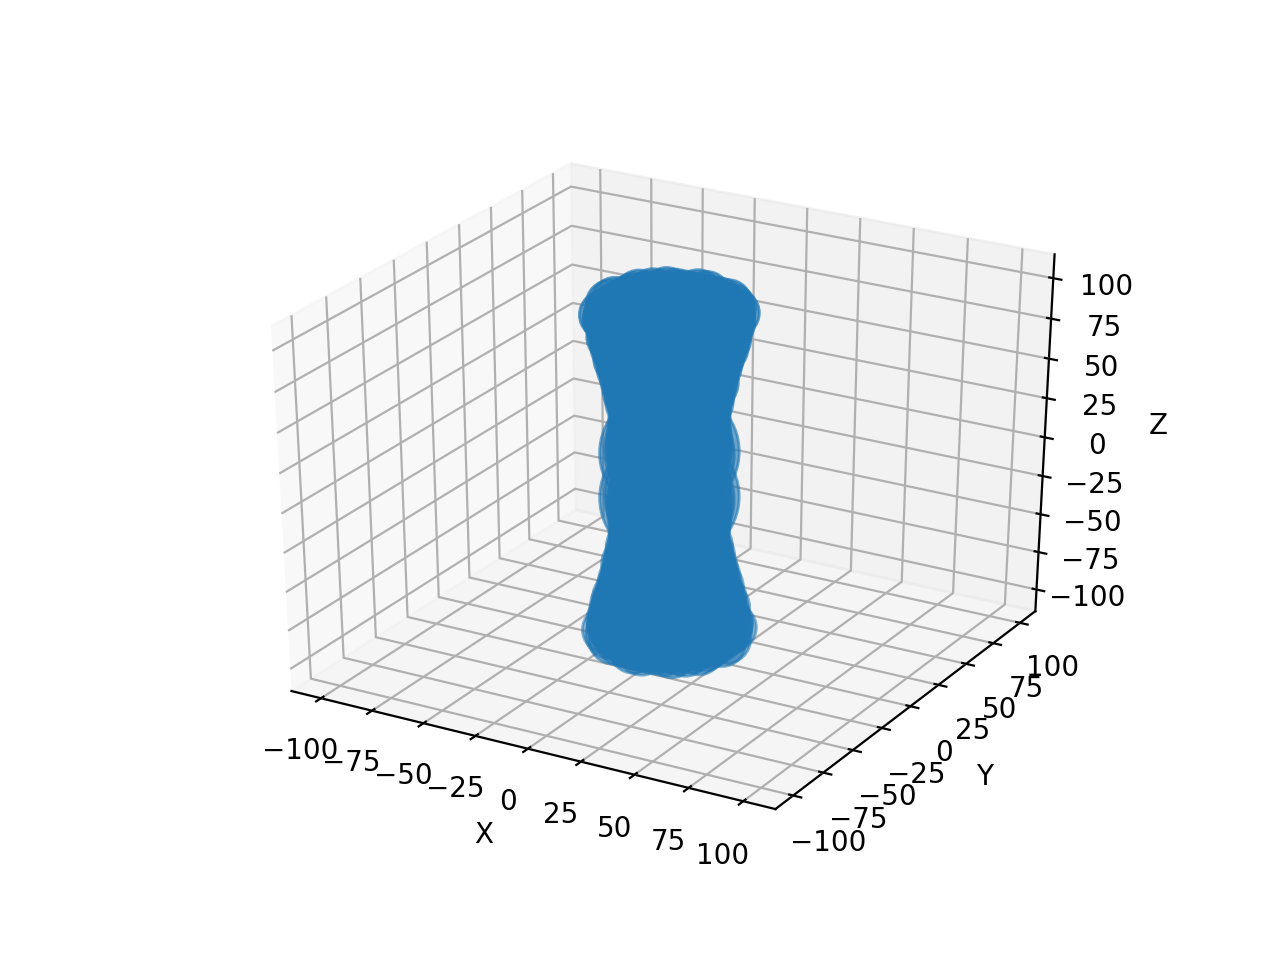

In [8]:
Npoints = 50
x, y, z = np.meshgrid(np.linspace(-100, 100, Npoints),
                      np.linspace(-100, 100, Npoints),
                      np.linspace(-100, 100, Npoints))



from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

D = 1
beta0 = np.pi/12
r0 = 0.3
x0 = 0
y0 = 0
z0 = 0
density = Wind_no_rotation_profile(D, beta0, np.arccos(abs(z - z0) / np.sqrt((x - x0) ** 2 + (y - y0) ** 2 + (z - z0) ** 2)), r0, np.sqrt((x - x0) ** 2 + (y - y0) ** 2 + (z - z0) ** 2)) 

ax.scatter(x, y, z, s = density * 1e5)
#ax.quiver(x, y_proj, z_proj, u, v_proj, w_proj, length=10, normalize=True)
# ax.set_xlim([-50, 50])
# ax.set_ylim([-50, 50])
# ax.set_zlim([-50, 50])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

<IPython.core.display.Javascript object>


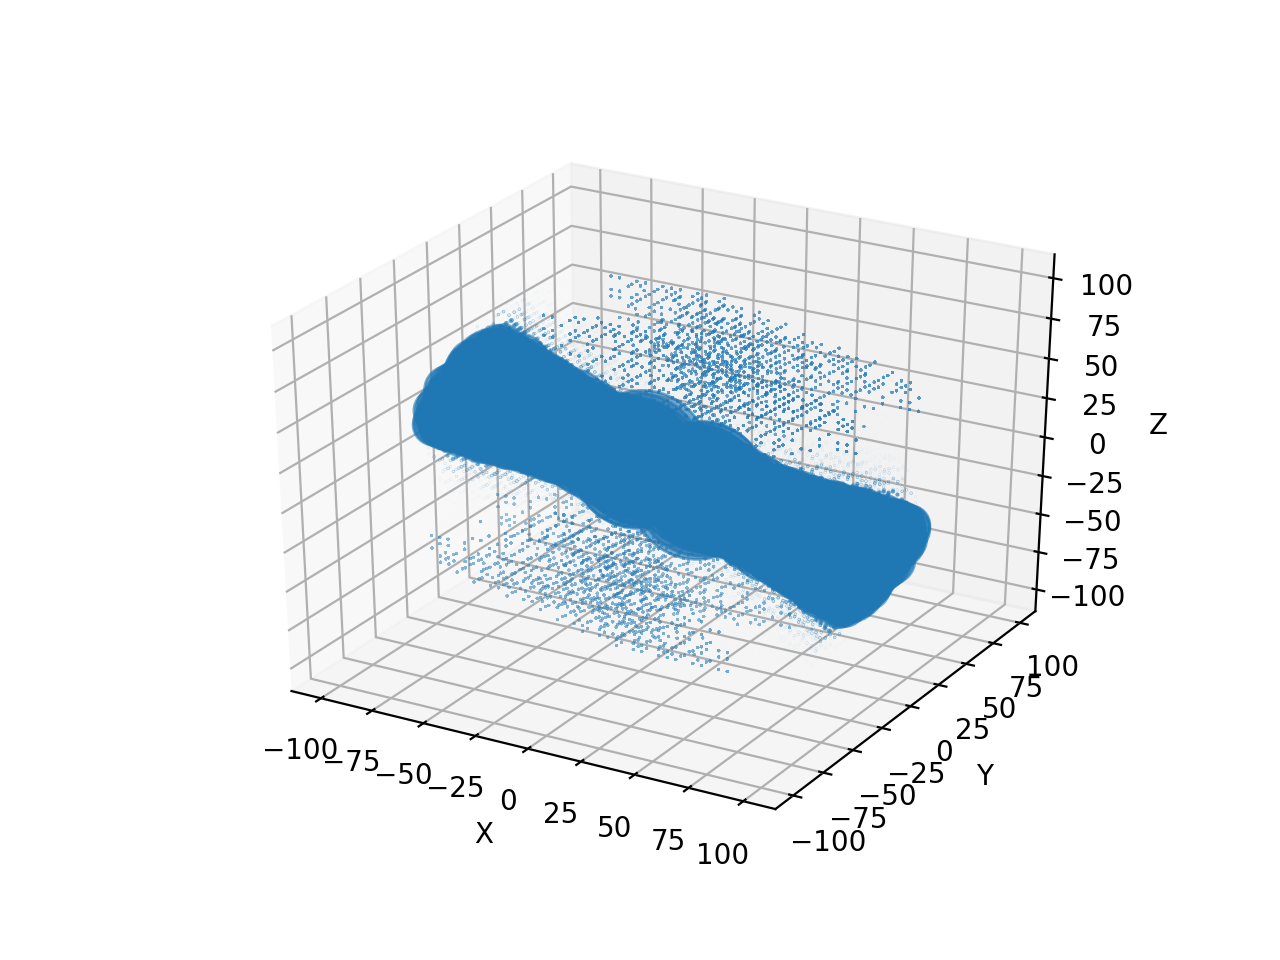

Text(0.5, 0, 'Z')

In [9]:
# rotate the matrix
from scipy.ndimage.interpolation import rotate

# angle: rotation angle in degrees
# theta: rotate in yz plane and projected along the y axis
# alpha: rotate in xz plane and projected along the y axis
q = 0.8052 
#theta = np.arccos(q) * 180 / np.pi
theta = 73
alpha = 40
density_rotated = rotate(input = density, angle = theta, axes = (1, 2), reshape = False)
density_rotated2 = rotate(input = density_rotated, angle = alpha, axes = (0, 2), reshape = False)



fig = plt.figure()
ax = fig.gca(projection='3d')


ax.scatter(x, y, z, s = density_rotated * 1e5)
#ax.quiver(x, y_proj, z_proj, u, v_proj, w_proj, length=10, normalize=True)
# ax.set_xlim([-50, 50])
# ax.set_ylim([-50, 50])
# ax.set_zlim([-50, 50])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


<IPython.core.display.Javascript object>


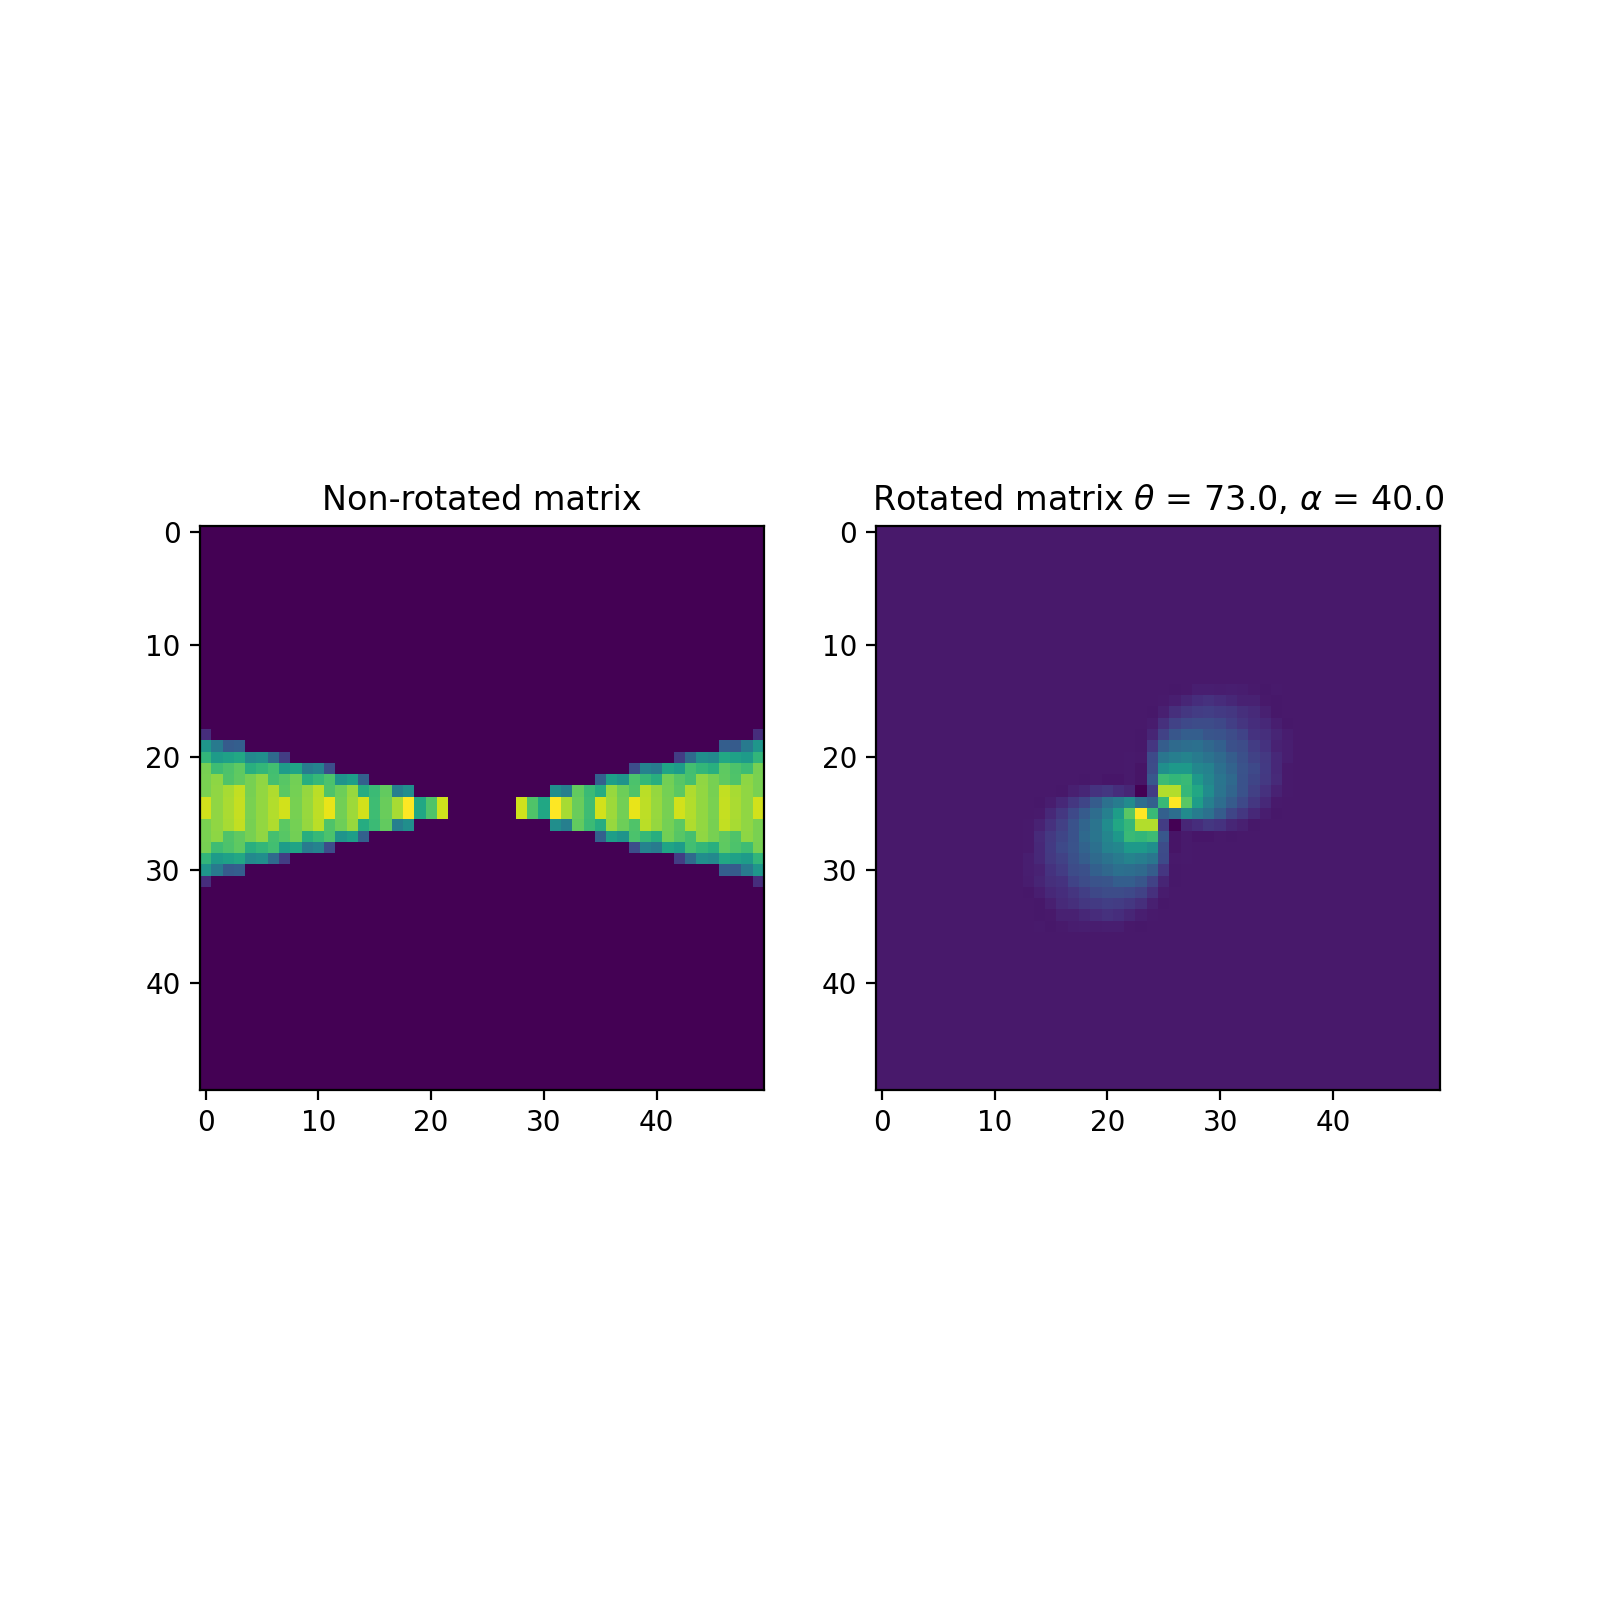

Text(0.5, 1.0, 'Rotated matrix $\\theta$ = 73.0, $\\alpha$ = 40.0')

In [10]:
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(density.sum(axis = 1))
plt.title('Non-rotated matrix')
#plt.contour(SNR, [20], colors = 'red')

plt.subplot(122)
plt.imshow(density_rotated2.sum(axis = 1))
plt.title(r'Rotated matrix $\theta$ = %.1f, $\alpha$ = %.1f' % (theta, alpha))

In [11]:
import scipy.optimize

In [12]:
def Wind_no_rotation_profile_gamma(D, gamma, beta0, beta, r0, r):
    return D * (r0 / r) ** gamma * np.heaviside(beta0 - beta, 0) * np.heaviside(r - r0, 0)


def Projected_wind(D, gamma, beta0, theta, alpha, r0, x, y, z):
    density = Wind_no_rotation_profile_gamma(D, gamma, beta0, np.arccos(abs(z) / np.sqrt(x ** 2 + y ** 2 + z ** 2)), r0, np.sqrt(x ** 2 + y ** 2 + z ** 2)) 
    density_rotated = rotate(input = density, angle = theta, axes = (1, 2), reshape = False)
    density_rotated2 = rotate(input = density_rotated, angle = alpha, axes = (0, 2), reshape = False)
    return density_rotated2.sum(axis = 1)

def err(p, r0, x, y, z, image):
    D = p[0]
    gamma = p[1]
    beta0 = p[2]
    theta = p[3]
    alpha = p[4]
    return (Projected_wind(D, gamma, beta0, theta, alpha, r0, x, y, z) - image).ravel()



In [13]:
d[np.isnan(d)] = 0
dim1, dim2 = d.shape
dim3 = max(dim1, dim2)
# Each pixel is 1.5091 kpc
scale = 1.5091
x, y, z = np.meshgrid(np.linspace(-0.5 * dim1 * scale, 0.5 * dim1 * scale, dim1), 
                      np.linspace(-0.5 * dim2 * scale, 0.5 * dim2 * scale, dim2), 
                      np.linspace(-0.5 * dim3 * scale, 0.5 * dim3 * scale, dim3))

# Initial guess of the parameters
D = 1
gamma = 1
beta0 = np.pi/10
r0 = 0.3
q = 0.8052 
theta = np.arccos(q) * 180 / np.pi
alpha = -45
p0 = [D, gamma, beta0, theta, alpha]

out = scipy.optimize.leastsq(err, p0, args = (r0, x, y, z, d * 1e16), full_output = 1)
print(out)

(array([  0.19959266,   0.2854562 ,   0.31415927,  73.73234236,
       -54.60746981]), None, {'fvec': array([0., 0., 0., ..., 0., 0., 0.]), 'nfev': 141, 'fjac': array([[-6.26615525e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.52540474e+01, -2.72100288e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.74804672e-01, -3.47423555e-01, -1.28275821e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.41413470e-04, -6.39861915e-05, -8.38080832e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]), 'ipvt': array([1, 2, 4, 5, 3], dtype=int32), 'qtf': array([ 1.58265952e-06, -3.19552861e-05,  2.75857056e-04,  2.35644283e-04,
        0.00000000e+00])}, 'Both actual and predicted relative reductions in the sum of sq

[  0.19959266   0.2854562    0.31415927  73.73234236 -54.60746981]
0.3141592653589793


<IPython.core.display.Javascript object>


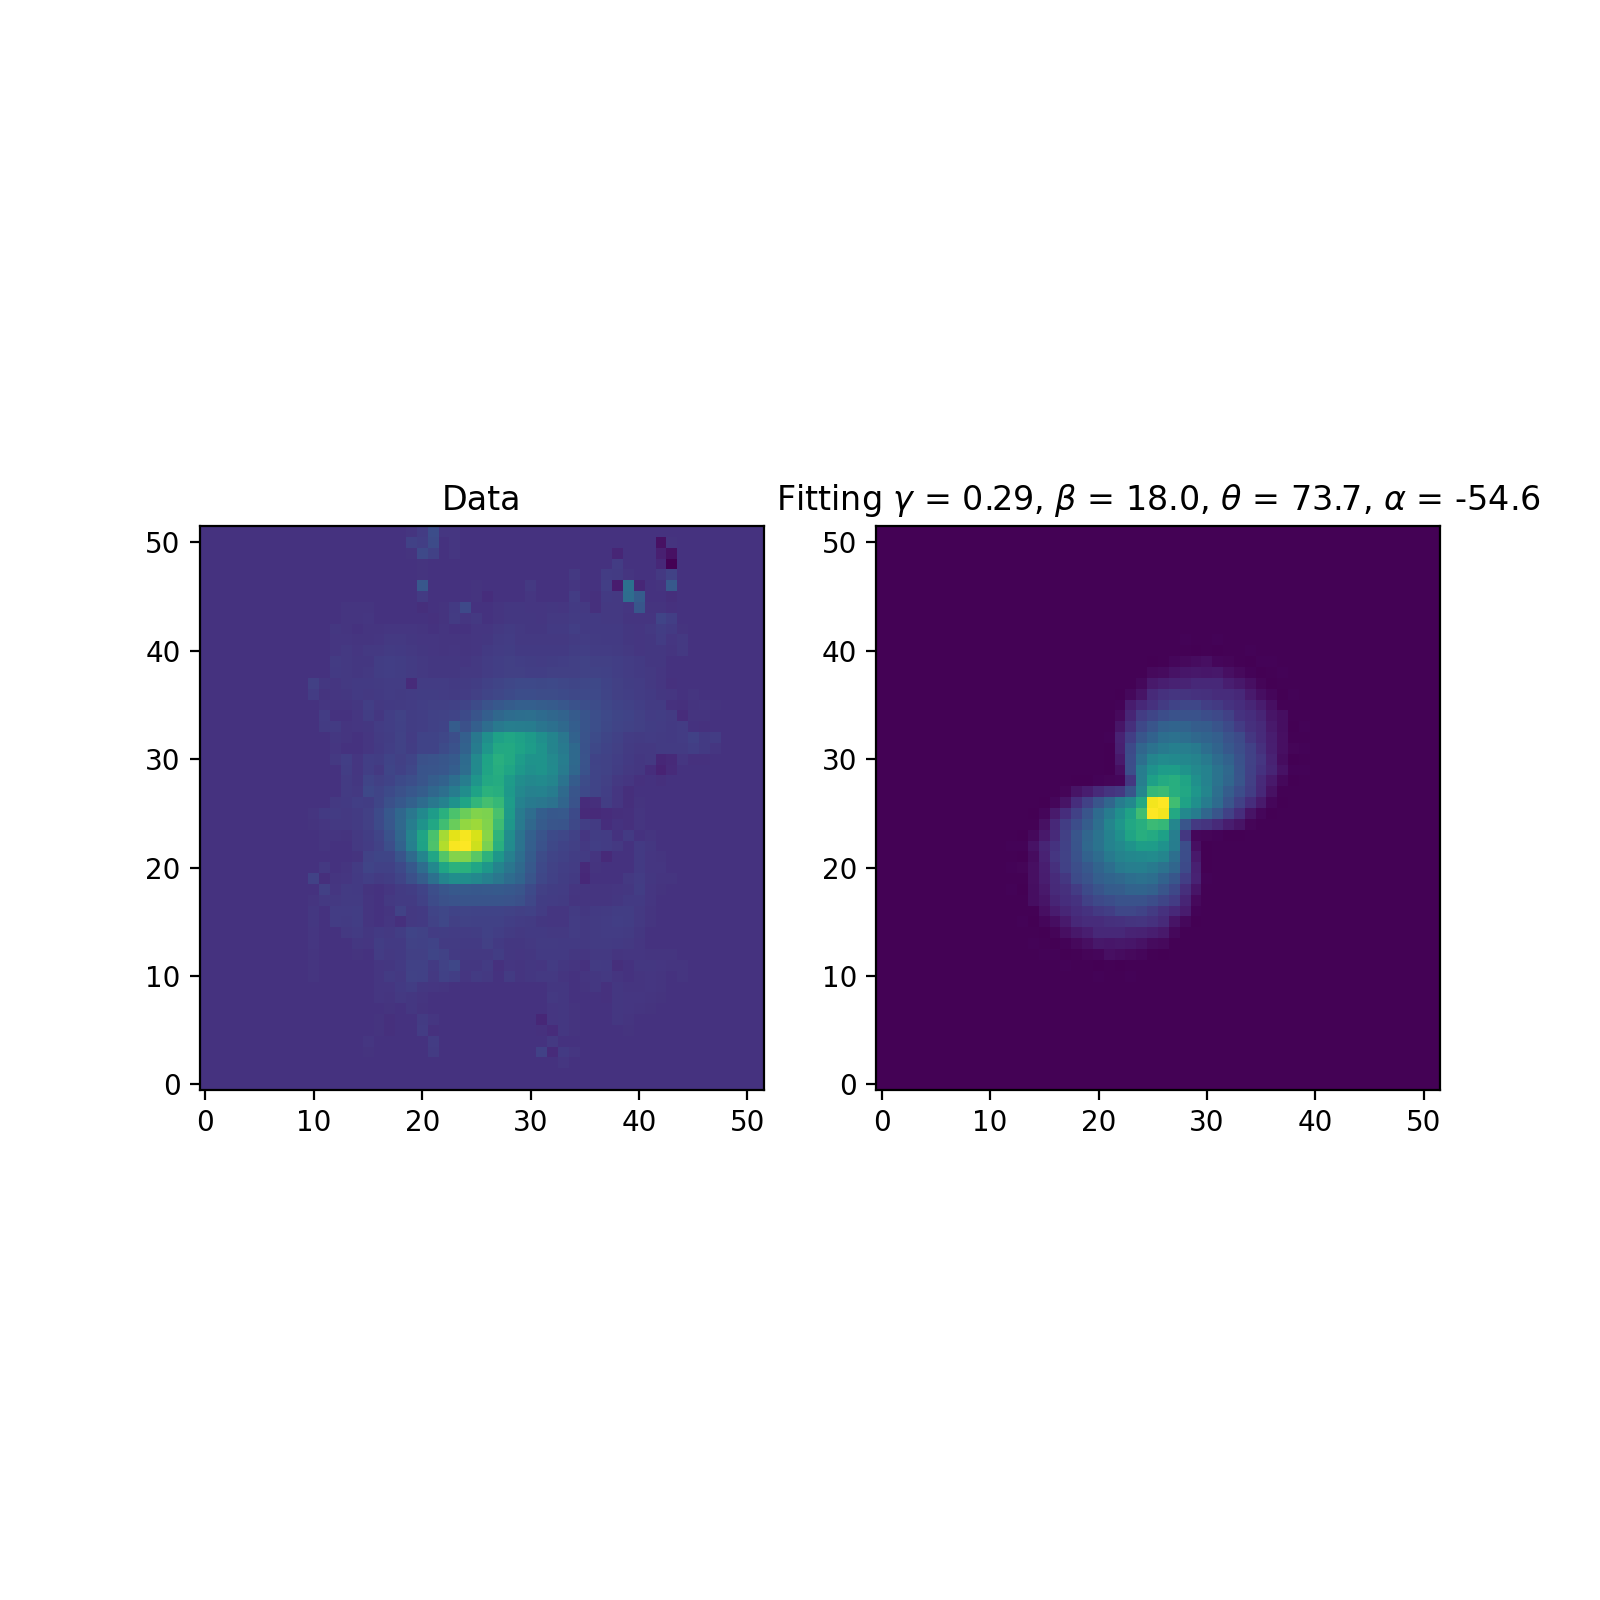

Text(0.5, 1.0, 'Fitting $\\gamma$ = 0.29, $\\beta$ = 18.0, $\\theta$ = 73.7, $\\alpha$ = -54.6')

In [14]:
p_best = out[0]
print(p_best)
print(beta0)

# n = 9
# # Within 5 * sigma confidence interval
# nstd = 5

##############################################
#### No Jacobian output! Fitting not good ####
##############################################
# # See the discussion here: 
# # https://stackoverflow.com/questions/14854339/in-scipy-how-and-why-does-curve-fit-calculate-the-covariance-of-the-parameter-es
# p_conv = np.sqrt(np.diag(out[1] * (out[2]['fvec']**2).sum() / (dim1 * dim2 - len(p0))))
# ier = out[-1]
# print(p_conv, ier)

plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(d * 1e16, origin = 'lower')
plt.title('Data')
#plt.contour(SNR, [20], colors = 'red')

plt.subplot(122)
plt.imshow(Projected_wind(*p_best, r0, x, y, z), origin = 'lower')
plt.title(r'Fitting $\gamma$ = %.2f, $\beta$ = %.1f, $\theta$ = %.1f, $\alpha$ = %.1f' % (p_best[1], p_best[2] * 180 / np.pi, p_best[3], p_best[4]))